# Предсказание данных **выживаемости на титанике**

In [19]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from models.pl_model import NeuralNetworkPL
from datasets.dataset import CustomDataset

### Подготовка данных

In [20]:
X = []
y = []

with open('../data/titanic/preprocessed_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    feature_titles = [key for key in reader.fieldnames if key != 'Survived']
    
    numerical_features = ['Age', 'Fare']
    selected_indices = [i for i, key in enumerate(feature_titles) if key in numerical_features]
    
    for row in reader:
        survived = float(row['Survived'])
        feature_values = [float(row[feature_titles[i]]) for i in selected_indices]  
        
        X.append(feature_values)
        y.append(survived)

X = np.array(X)
y = np.array(y).reshape(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_dataset = CustomDataset(X_train_scaled, y_train)
val_dataset = CustomDataset(X_val_scaled, y_val)
test_dataset = CustomDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=5, persistent_workers=True)

### Обучение модели

In [21]:
from pytorch_lightning.callbacks import EarlyStopping

input_layer_size = X_train.shape[1]
unique_labels = np.unique(y_train)
n_classes = len(unique_labels)

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
model = NeuralNetworkPL(
    input_size=input_layer_size,
    hidden_sizes=[100, 50],
    output_size=n_classes,
    activation='relu',
    task='classification'
)

trainer = pl.Trainer(max_epochs=500, accelerator="auto", log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 5.5 K  | train
--------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 18/18 [00:00<00:00, 166.29it/s, v_num=17]       

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 18/18 [00:00<00:00, 157.20it/s, v_num=17]


### Тестирование

In [22]:
trainer.test(model, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 140.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5664613842964172     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5664613842964172}]

### Визуализация

Test F1-score: 45.28%


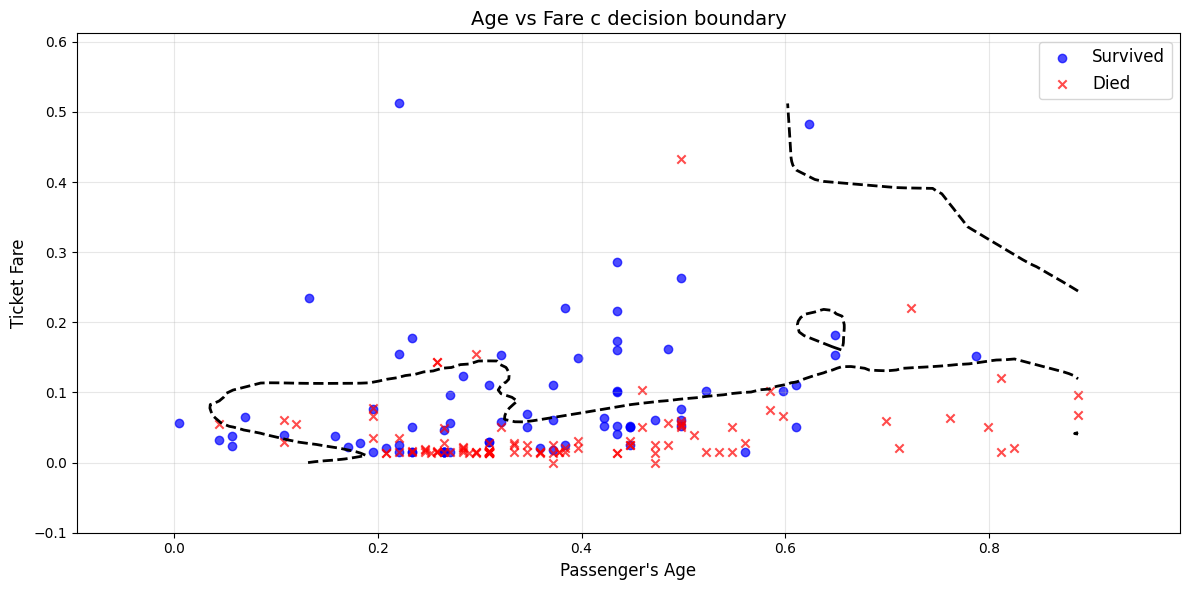

In [23]:
from sklearn.metrics import f1_score

y_pred_probs = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

age = X_test_scaled[:, 0]
fare = X_test_scaled[:, 1]

if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_flat = np.argmax(y_test, axis=1)
else:
    y_test_flat = y_test.flatten().astype(int)
    
f1 = f1_score(y_test_flat, y_pred_labels)
print(f"Test F1-score: {f1 * 100:.2f}%")

survived_age = age[y_test_flat == 1]
survived_fare = fare[y_test_flat == 1]
died_age = age[y_test_flat == 0]
died_fare = fare[y_test_flat == 0]

plt.figure(figsize=(12, 6))
plt.scatter(survived_age, survived_fare, color='blue', label='Survived', alpha=0.7, marker='o')
plt.scatter(died_age, died_fare, color='red', label='Died', alpha=0.7, marker='x')

x1_vals = np.linspace(age.min(), age.max(), 100)
x2_vals = np.linspace(fare.min(), fare.max(), 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[X1.ravel(), X2.ravel()]

Z_probs = model.predict(grid_points)
Z_class = Z_probs[:, 1].reshape(X1.shape)

plt.contour(X1, X2, Z_class, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)

plt.title('Age vs Fare с decision boundary', fontsize=14)
plt.xlabel("Passenger's Age", fontsize=12)
plt.ylabel("Ticket Fare", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(age.min() - 0.1, age.max() + 0.1)
plt.ylim(fare.min() - 0.1, fare.max() + 0.1)
plt.tight_layout()
plt.show()